In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from keras.regularizers import l2

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.shape

(5572, 2)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0.5, 1.0, 'Number of ham and spam messages')

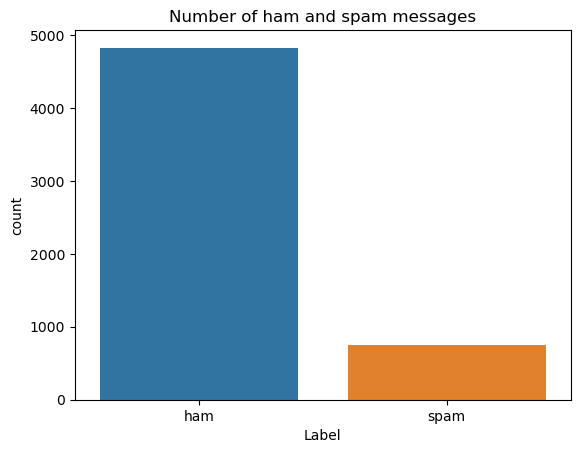

In [6]:
sns.countplot(x='v1',data=df)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [7]:
le = LabelEncoder()
df['v1'] = le.fit_transform(df['v1'])

In [8]:
max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(df['v2'].values)
X = tokenizer.texts_to_sequences(df['v2'].values)
X = pad_sequences(X, maxlen=max_len)

In [9]:
Y = to_categorical(df['v1'])

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [11]:
Y_train = Y_train[:, 1]  # Assuming positive class is encoded as 1 in Y_train
Y_test = Y_test[:, 1]    # Assuming positive class is encoded as 1 in Y_test

In [12]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}


In [13]:
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_words,128,input_length=max_len))
model.add(LSTM(128,dropout=0.2, recurrent_dropout=0.2, kernel_regularizer='l2'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 267,905
Trainable params: 267,905
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train,Y_train,epochs=20,batch_size=32,validation_data=(X_test, Y_test))

Epoch 1/20
148/148 [==============================] - 88s 571ms/step - loss: 0.6320 - accuracy: 0.9322 - val_loss: 0.0944 - val_accuracy: 0.9809
Epoch 2/20
148/148 [==============================] - 84s 567ms/step - loss: 0.0758 - accuracy: 0.9844 - val_loss: 0.0793 - val_accuracy: 0.9821
Epoch 3/20
148/148 [==============================] - 80s 542ms/step - loss: 0.0511 - accuracy: 0.9897 - val_loss: 0.0689 - val_accuracy: 0.9821
Epoch 4/20
148/148 [==============================] - 83s 563ms/step - loss: 0.0343 - accuracy: 0.9937 - val_loss: 0.0830 - val_accuracy: 0.9797
Epoch 5/20
148/148 [==============================] - 83s 559ms/step - loss: 0.0317 - accuracy: 0.9932 - val_loss: 0.1136 - val_accuracy: 0.9761
Epoch 6/20
148/148 [==============================] - 82s 555ms/step - loss: 0.0268 - accuracy: 0.9951 - val_loss: 0.0796 - val_accuracy: 0.9844
Epoch 7/20
148/148 [==============================] - 81s 546ms/step - loss: 0.0220 - accuracy: 0.9970 - val_loss: 0.0868 - val_ac

In [15]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

Test loss: 0.1526, Test accuracy: 0.9844


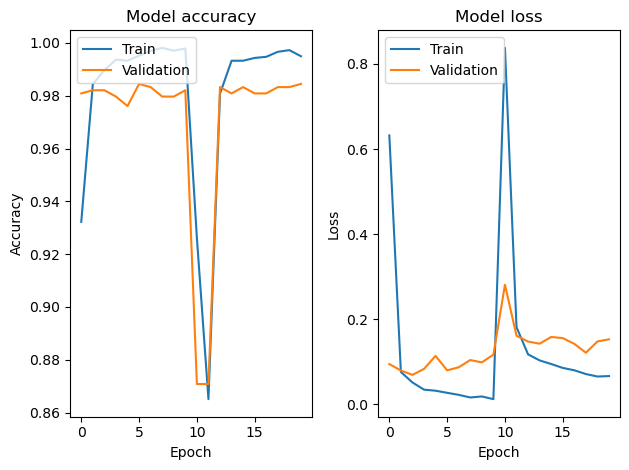

In [16]:
# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this should work
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [17]:
#things we will do here are
# correct the class imbalance
# apply some more metrics for result
# regularization techniques
# cross validation

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for the test set
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Generate classification report
class_report = classification_report(Y_test, Y_pred, target_names=['ham', 'spam'])

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


27/27 [==============================] - 2s 86ms/step
Confusion Matrix:
[[724   4]
 [  9  99]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       728
        spam       0.96      0.92      0.94       108

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836

